In [14]:
import matplotlib.pyplot as plt
import numpy as np
import random

X_range = np.array([600, 625, 650, 675, 700, 725, 750, 775, 800])
# num_iter = 10
# steps = len(X_range)

In [15]:
def calc_slope(metric):
    slope = np.array([(metric[i+1] - metric[i])/(X_range[i+1] - X_range[i]) for i in range(len(X_range)-2)])
    return slope

def corrected(metric, offset, slope, r):
    metric[0] *= r*offset
    metric[1:] = [(metric[i-1] + (X_range[i]-X_range[i-1])*slope[i-1]) for i in range(1, len(metric))]
    metric = np.array(metric)
    return metric
    

In [16]:
class simulation():
    def __init__(self, srcr, tur, nsp):
        self.SRCR = srcr        
        self.TUR = tur        
        self.NSP = nsp        
        
        self.srcr_slope = calc_slope(self.SRCR)
        self.tur_slope = calc_slope(self.TUR)
        self.nsp_slope = calc_slope(self.NSP)

    @classmethod
    def add(cls, *obj):
        srcr = np.zeros(len(X_range))
        tur = np.zeros(len(X_range))
        nsp = np.zeros(len(X_range))
        
        for item in obj: 
            srcr += item.SRCR
            tur += item.TUR 
            nsp += item.NSP 
        # srcr_slope = obj1.srcr_slope + obj2.srcr_slope
        # tur_slope = obj1.tur_slope + obj2.tur_slope
        # nsp_slope = obj1.nsp_slope + obj2.nsp_slope

        res = cls(srcr, tur, nsp)
        return res
        
    def offset(self, obj):
        srcr_correction = obj.SRCR/self.SRCR
        tur_correction = obj.TUR/self.TUR
        nsp_correction = obj.NSP/self.NSP

        return srcr_correction, tur_correction, nsp_correction

    
    def fuzzy_scale(self, obj, fuzzy = 'around', distr = 'uniform'):
        
        (lb, ub) = (950, 1000) if fuzzy == 'around' else (925, 975) if fuzzy == 'below' else (980, 1000) if fuzzy == 'brute' else (999, 1000)  
        
        if distr == 'uniform':
            r = np.array([random.randrange(lb, ub)/1000 for _ in range(steps)])
            
        elif distr == 'gaussian':
            std_dev = 0.025
            mean = (lb+ub)/2000
            
            r = np.random.normal(loc=mean, scale=std_dev, size=steps)

        r_sorted = np.sort(r).astype('float')
        # print(r_sorted, (lb, ub))

        if fuzzy == 'brute':
            srcr = obj.SRCR*r
            tur = obj.TUR/r
            nsp = obj.NSP*r
    
            self = simulation(srcr, tur, nsp)
            return self.SRCR, self.TUR, self.NSP

        srcr_correction, tur_correction, nsp_correction = self.offset(obj)

        self.SRCR *= srcr_correction*r_sorted
        self.TUR *= tur_correction/r_sorted    # Because sim.tur > obj.tur
        self.NSP *= nsp_correction*r_sorted

        return srcr_correction, tur_correction, nsp_correction
        

    @classmethod
    def duplicate(cls, target, distr = 'uniform'):
                    
        std_dev = 0.025

        if distr == 'uniform':
            r = np.array([random.randrange(980, 1000)/1000 for _ in range(steps)])
            
        elif distr == 'gaussian':
            std_dev = 0.025
            mean = 0.98

            r = np.random.normal(loc=mean, scale=std_dev, size=steps)

        r_sorted = np.sort(r).astype('float')
        
        srcr = target.SRCR*r
        tur = target.TUR/r
        nsp = target.NSP*r

        return cls(srcr, tur, nsp)         


In [17]:
class fbr():
    def __init__(self, SRCR_assl, TUR_assl, NSP_assl, SRCR_awsl, TUR_awsl, NSP_awsl):
        self.assl = simulation(SRCR_assl, TUR_assl, NSP_assl)   
        self.awsl = simulation(SRCR_awsl, TUR_awsl, NSP_awsl)

    def fbr_fuzzy_scale(self, obj, fuzzy = 'around'):
        
        if fuzzy not in ['exact', 'around', 'worse']: return False
            
        srcr_correction, tur_correction, nsp_correction = self.offset(obj)

        std_dev = 0.025
        if fuzzy == 'around': 
            mean = 1
            r = np.sort(np.random.normal(loc=mean, scale=std_dev, size=len(X_range)))
            
        elif fuzzy == 'below': 
            mean = 0.975
            r = np.sort(np.random.normal(loc=mean, scale=std_dev, size=len(X_range)))
            
        else: r = 1
        # r = np.sort(np.array([random.randrange(950, 999)/1000 for _ in range(len(X_range))]))

        self.SRCR *= srcr_correction*r
        self.TUR *= tur_correction/r    # Because sim.tur > obj.tur
        self.NSP *= nsp_correction*r

        return srcr_correction, tur_correction, nsp_correction

    def duplicate(self, obj):
        srcr_correction, tur_correction, nsp_correction = self.offset(obj)
    
        std_dev = 0.025
        mean = 0.97
        r = np.sort(np.random.normal(loc=mean, scale=std_dev, size=len(X_range)))
            
        # r = np.sort(np.array([random.randrange(950, 999)/1000 for _ in range(len(X_range))]))
    
        self.SRCR *= srcr_correction*r
        self.TUR *= tur_correction/r    # Because sim.tur > obj.tur
        self.NSP *= nsp_correction*r
    
        return srcr_correction, tur_correction, nsp_correction

In [18]:
def fbr_plot_simulation(obj, set_ticks=True):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))    # 1 column for SRCR and TUR, another for NSP
    
    ax1.plot(X_range, obj.assl.SRCR, label='ASSL', linewidth = 0.3)
    ax1.plot(X_range, obj.awsl.SRCR, label='AWSL', linewidth = 0.3)
    
    ax2.plot(X_range, obj.assl.TUR, label='ASSL', linewidth = 0.3)
    ax2.plot(X_range, obj.awsl.TUR, label='AWSL', linewidth = 0.3)
    
    ax3.plot(X_range, obj.assl.NSP, label='ASSL', linewidth = 0.3)
    ax3.plot(X_range, obj.awsl.NSP, label='AWSL', linewidth = 0.3)
    
    
    ax1.scatter(X_range, obj.assl.SRCR, label='ASSL', marker = 's', s=10)
    ax1.scatter(X_range, obj.awsl.SRCR, label='AWSL', marker = '^', s=10)
    
    ax2.scatter(X_range, obj.assl.TUR, label='ASSL', marker = 's', s=10)
    ax2.scatter(X_range, obj.awsl.TUR, label='AWSL', marker = '^', s=10)
    
    ax3.scatter(X_range, obj.assl.NSP, label='ASSL', marker = 's', s=10)
    ax3.scatter(X_range, obj.awsl.NSP, label='AWSL', marker = '^', s=10)
    
    
    ax1.set_xlabel('X = Number of CRs')
    ax1.set_ylabel('SRCR')
    ax1.set_title("SRCR vs X")
    ax1.minorticks_on()
    ax1.legend(loc='best')
    
    ax2.set_xlabel('X = Number of CRs')
    ax2.set_ylabel('TUR')
    ax2.set_title("TUR vs X")
    ax2.minorticks_on()
    ax2.legend()
    
    ax3.set_xlabel('X = Number of CRs')
    ax3.set_ylabel('NSP')
    ax3.set_title("NSP vs X")
    ax3.minorticks_on()
    ax3.legend(loc='best')

    if set_ticks:
        ax1.set_yticks(np.arange(76, 98, 2)/100)
        ax2.set_yticks(np.arange(40, 80, 5)/100)
        ax3.set_yticks(np.arange(1400, 3000, 200))
     
    fig.suptitle(f"Network Evaluation for k = 1  averaged over {num_iter} iterations", y=1.05)

    # Show the plot
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

In [19]:
def plot_comparision(objects, labels, ppr = True, show=True, set_ticks = True):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))    # 1 column for SRCR and TUR, another for NSP
    markers = ["^", "o", "x", "<", ">", '*', '.', 'x', 'X', '+','P', 'D',' d','p ','H' ,'h', 'v', '1','2 ','3', '4', '|', '_', ',']

    for i, (obj, label) in enumerate(zip(objects, labels)):
        ax1.plot(X_range, obj.SRCR, label = label, linewidth = 0.3, marker = markers[i], markersize=3)        
        ax2.plot(X_range, obj.TUR, label = label, linewidth = 0.3, marker = markers[i], markersize=3)        
        ax3.plot(X_range, obj.NSP, label = label, linewidth = 0.3, marker = markers[i], markersize=3)        
        
    if ppr:
        ax1.plot(X_range, paper.assl.SRCR, label = 'Paper-ASSL', linewidth = 0.5, marker = "s", markersize=3)        
        ax2.plot(X_range, paper.assl.TUR, label = 'Paper-ASSL', linewidth = 0.5, marker = "s", markersize=3)        
        ax3.plot(X_range, paper.assl.NSP, label = 'Paper-ASSL', linewidth = 0.5, marker = "s", markersize=3)        
        # ax1.scatter(X_range, obj.SRCR, label = label, marker = markers[i], s=10)        
        # ax2.scatter(X_range, obj.TUR, label = label, marker = markers[i], s=10)        
        # ax3.scatter(X_range, obj.NSP, label = label, marker = markers[i], s=10)    
        
    
    ax1.set_xlabel('X = Number of CRs')
    ax1.set_ylabel('SRCR')
    ax1.set_title("SRCR vs X")
    ax1.minorticks_on()
    ax1.legend(loc='best')
    
    ax2.set_xlabel('X = Number of CRs')
    ax2.set_ylabel('TUR')
    ax2.set_title("TUR vs X")
    ax2.minorticks_on()
    ax2.legend()
    
    ax3.set_xlabel('X = Number of CRs')
    ax3.set_ylabel('NSP')
    ax3.set_title("NSP vs X")
    ax3.minorticks_on()
    ax3.legend(loc='best')

    if set_ticks:
        ax1.set_yticks(np.arange(76, 98, 2)/100)
        ax2.set_yticks(np.arange(40, 80, 5)/100)
        ax3.set_yticks(np.arange(1400, 3000, 200))

    fig.suptitle(f"Network Evaluation for k = 1  averaged over {num_iter} iterations", y=1.05)

    # Show the plot
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()
    

In [20]:
def plot_simulation(obj, set_ticks = False):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))    # 1 column for SRCR and TUR, another for NSP
    
    ax1.plot(X_range, obj.SRCR, linewidth = 0.3)    
    ax2.plot(X_range, obj.TUR, linewidth = 0.3)    
    ax3.plot(X_range, obj.NSP, linewidth = 0.3)    
    
    ax1.scatter(X_range, obj.SRCR, marker = 's', s=10)    
    ax2.scatter(X_range, obj.TUR, marker = 's', s=10)    
    ax3.scatter(X_range, obj.NSP, marker = 's', s=10)    
    
    ax1.set_xlabel('X = Number of CRs')
    ax1.set_ylabel('SRCR')
    ax1.set_title("SRCR vs X")
    ax1.minorticks_on()
    # ax1.legend(loc='best')
    
    ax2.set_xlabel('X = Number of CRs')
    ax2.set_ylabel('TUR')
    ax2.set_title("TUR vs X")
    ax2.minorticks_on()
    # ax2.legend()
    
    ax3.set_xlabel('X = Number of CRs')
    ax3.set_ylabel('NSP')
    ax3.set_title("NSP vs X")
    ax3.minorticks_on()
    # ax3.legend(loc='best')

    if set_ticks:
        ax1.set_yticks(np.arange(76, 98, 2)/100)
        ax2.set_yticks(np.arange(40, 80, 5)/100)
        ax3.set_yticks(np.arange(1400, 3000, 200))
        
    fig.suptitle(f"Network Evaluation for k = 1  averaged over {num_iter} iterations", y=1.05)

    # Show the plot
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

# Paper Details

## ASSL

In [21]:
SRCR_assl = np.array([0.945, 0.93, 0.92, 0.91, 0.9, 0.889, 0.877, 0.856, 0.844])
TUR_assl = np.array([0.575, 0.59, 0.605, 0.622, 0.638, 0.655, 0.666, 0.673, 0.68])
NSP_assl = np.array([2310, 2365, 2420, 2490, 2545, 2590, 2635, 2670, 2720])

## AWSL

In [ ]:
SRCR_awsl = np.array([0.939, 0.92, 0.91, 0.90, 0.883, 0.875, 0.859, 0.84, 0.828])
TUR_awsl = np.array([0.57, 0.58, 0.595, 0.61, 0.618, 0.633, 0.643, 0.647, 0.655])
NSP_awsl = np.array([2240, 2280, 2340, 2410, 2437, 2495, 2535, 2565, 2610])

## SSL

In [ ]:
SRCR_ssl = [0.918, 0.898, 0.887, 0.875, 0.858, 0.849, 0.833, 0.812, 0.801] 
TUR_ssl = [0.553, 0.568, 0.576, 0.59, 0.598, 0.612, 0.623, 0.628, 0.633]
NSP_ssl = 

In [ ]:
paper = fbr(SRCR_assl, TUR_assl, NSP_assl, SRCR_awsl, TUR_awsl, NSP_awsl)

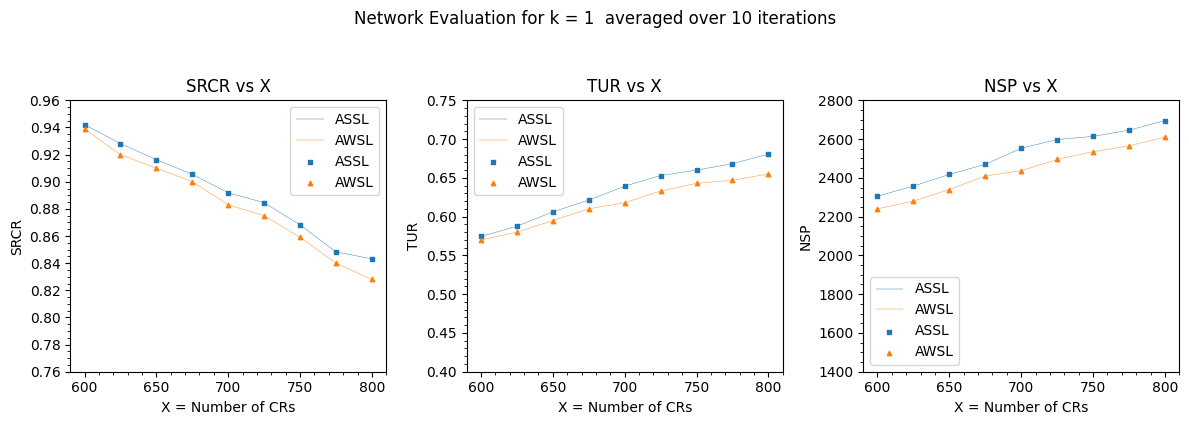

In [29]:
fbr_plot_simulation(paper)

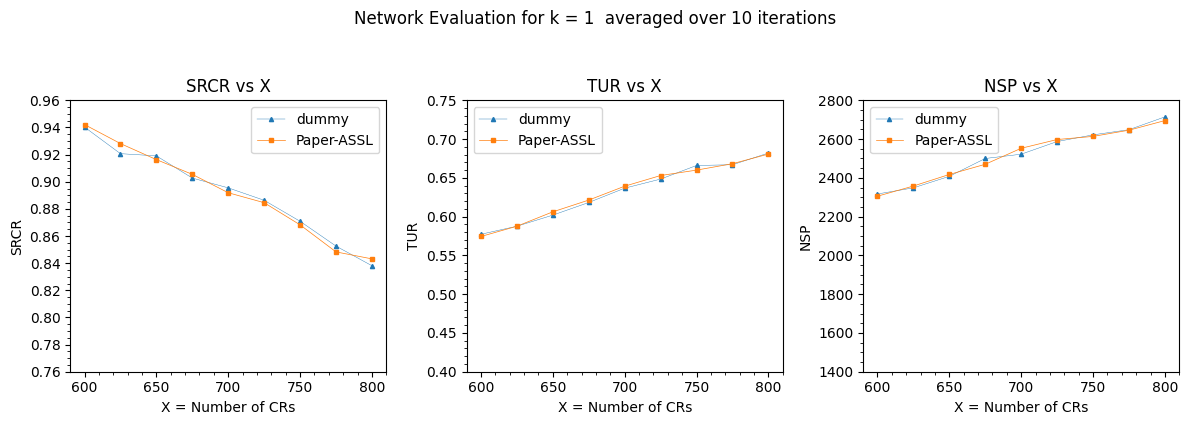

In [30]:
SRCR_dummy = np.array([SRCR_assl[i]*random.randrange(990, 1000)/1000 for i in range(steps)])
TUR_dummy = np.array([TUR_assl[i]*random.randrange(990, 1005)/1000 for i in range(steps)])
NSP_dummy = np.array([NSP_assl[i]*random.randrange(990, 1005)/1000 for i in range(steps)])

# num_iter = 10
dummy = simulation(SRCR_dummy, TUR_dummy, NSP_dummy)
plot_comparision([dummy], ['dummy'])

In [31]:
SRCR_assl, TUR_assl, NSP_assl

(array([0.940275, 0.9207  , 0.91908 , 0.90272 , 0.8955  , 0.886333,
        0.870861, 0.852576, 0.838092]),
 array([0.5773  , 0.58764 , 0.601975, 0.618268, 0.636724, 0.64845 ,
        0.666   , 0.666943, 0.68204 ]),
 array([2316.93 , 2348.445, 2407.9  , 2499.96 , 2522.095, 2587.41 ,
        2621.825, 2648.64 , 2714.56 ]))

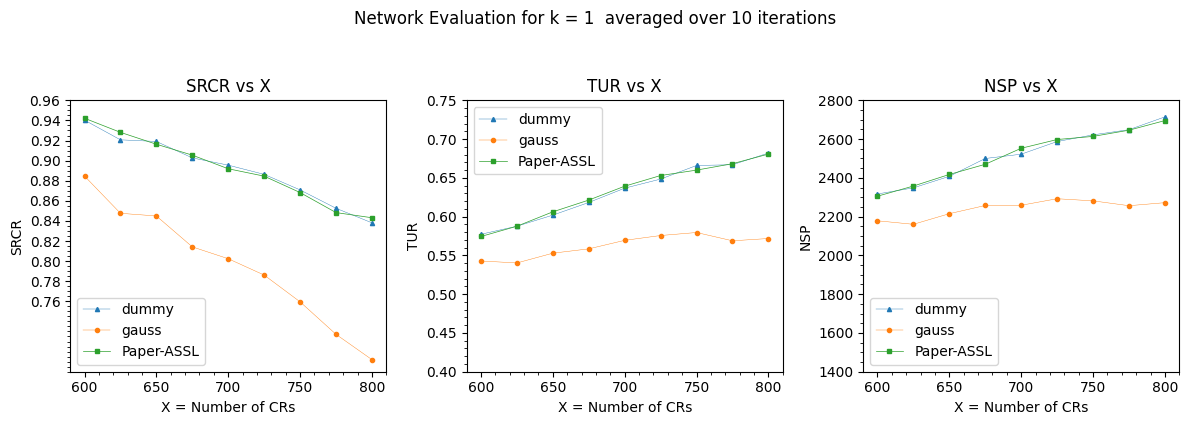

In [38]:
# np.random.normal(loc=mean, scale=std_dev, size=steps)
gauss_srcr = SRCR_assl * np.array([np.random.normal(loc = SRCR_assl[i], scale = SRCR_assl[i]/1000) for i in range(steps)])
gauss_tur = SRCR_assl * np.array([np.random.normal(loc = TUR_assl[i], scale = TUR_assl[i]/1000) for i in range(steps)])
gauss_nsp = SRCR_assl * np.array([np.random.normal(loc = NSP_assl[i], scale = NSP_assl[i]/1000) for i in range(steps)])
mod_gauss = simulation(gauss_srcr, gauss_tur, gauss_nsp)

plot_comparision([dummy, mod_gauss], ['dummy', 'gauss'])

# My simulation

In [13]:
# sim = fbr(SRCR_assl, TUR_assl, NSP_assl, SRCR_awsl, TUR_awsl, NSP_awsl)